In [84]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings("ignore")

import pickle

In [85]:
data = pd.read_csv('Hourly-2019.csv')
data.head()

,Date Time,T (degC),Spec_H (g/kg),Rel_H (5),Prep (mm/hr),Pressure (kPa),WV (10M),WD (10M),WV (50M),WD (50M),AllSky_Irr (Wh/m^2),Clrsky_Irr (Wh/m^2),Zenith
0,01.01.2019 00:00,27.40,19.29,84.38,1.09,100.57,0.90,84.54,1.06,88.30,0.0,0.0,NaN
1,01.01.2019 01:00,27.20,19.23,85.19,1.51,100.51,1.09,107.53,1.30,111.16,0.0,0.0,NaN
2,01.01.2019 02:00,26.96,19.23,86.25,1.88,100.47,1.40,119.15,1.71,122.09,0.0,0.0,NaN
3,01.01.2019 03:00,26.76,19.23,87.38,1.97,100.46,1.80,116.34,2.22,118.55,0.0,0.0,NaN
4,01.01.2019 04:00,26.61,19.35,88.56,1.80,100.48,2.32,110.33,2.94,112.14,0.0,0.0,NaN


In [86]:
data['Date Time'] = pd.to_datetime(data['Date Time'])
data['year'] = data['Date Time'].dt.year
data['month'] = data['Date Time'].dt.month
data['day of month'] = data['Date Time'].dt.day
data['day of year'] = data['Date Time'].dt.day_of_year
data['hour'] = data['Date Time'].dt.hour
data.drop_duplicates(subset='Date Time',inplace=True)
data.sort_values(by='Date Time', inplace=True)
data.tail()

,Date Time,T (degC),Spec_H (g/kg),Rel_H (5),Prep (mm/hr),Pressure (kPa),WV (10M),WD (10M),WV (50M),WD (50M),AllSky_Irr (Wh/m^2),Clrsky_Irr (Wh/m^2),Zenith,year,month,day of month,day of year,hour
8755,2019-12-31 19:00:00,27.46,20.26,88.44,0.04,100.61,5.26,18.54,6.88,18.48,0.0,0.0,NaN,2019,12,31,365,19
8756,2019-12-31 20:00:00,27.41,20.39,89.12,0.04,100.68,5.22,21.23,6.75,21.25,0.0,0.0,NaN,2019,12,31,365,20
8757,2019-12-31 21:00:00,27.34,20.45,89.81,0.05,100.70,5.15,24.16,6.61,24.29,0.0,0.0,NaN,2019,12,31,365,21
8758,2019-12-31 22:00:00,27.26,20.45,90.38,0.07,100.68,5.07,28.62,6.49,28.88,0.0,0.0,NaN,2019,12,31,365,22
8759,2019-12-31 23:00:00,27.15,20.45,90.69,0.07,100.64,5.14,34.41,6.58,35.09,0.0,0.0,NaN,2019,12,31,365,23


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8712 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date Time             8712 non-null   datetime64[ns]
 1   T (degC)              8712 non-null   float64       
 2    Spec_H (g/kg)        8712 non-null   float64       
 3   Rel_H (5)             8712 non-null   float64       
 4   Prep (mm/hr)          8712 non-null   float64       
 5   Pressure (kPa)        8712 non-null   float64       
 6   WV (10M)              8712 non-null   float64       
 7   WD (10M)              8712 non-null   float64       
 8   WV (50M)              8712 non-null   float64       
 9   WD (50M)              8712 non-null   float64       
 10  AllSky_Irr (Wh/m^2)   8712 non-null   float64       
 11  Clrsky_Irr (Wh/m^2)   8712 non-null   float64       
 12  Zenith                4616 non-null   float64       
 13  year              

In [88]:
data.describe()

,T (degC),Spec_H (g/kg),Rel_H (5),Prep (mm/hr),Pressure (kPa),WV (10M),WD (10M),WV (50M),WD (50M),AllSky_Irr (Wh/m^2),Clrsky_Irr (Wh/m^2),Zenith,year,month,day of month,day of year,hour
count,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,4616.000000,8712.0,8712.000000,8712.000000,8712.000000,8712.000000
mean,27.662611,19.009182,82.119928,0.329581,100.589130,2.645806,182.034230,3.171598,182.038239,217.378215,281.018822,51.028286,2019.0,6.506887,15.746556,182.443526,11.500000
std,1.307863,0.945315,6.481168,0.658988,0.163397,1.142714,124.990651,1.427117,124.294452,288.163910,357.036325,24.092513,0.0,3.447852,8.793922,105.392490,6.922584
min,23.940000,15.690000,59.190000,0.000000,100.060000,0.040000,0.000000,0.030000,0.000000,0.000000,0.000000,4.440000,2019.0,1.000000,1.000000,1.000000,0.000000
25%,26.700000,18.370000,77.620000,0.030000,100.480000,1.820000,40.587500,2.100000,41.610000,0.000000,0.000000,30.710000,2019.0,4.000000,8.000000,91.000000,5.750000
50%,27.570000,19.040000,83.250000,0.100000,100.590000,2.630000,216.470000,3.130000,215.335000,12.450000,12.250000,48.945000,2019.0,7.000000,16.000000,182.000000,11.500000
75%,28.540000,19.650000,87.380000,0.340000,100.700000,3.410000,293.170000,4.150000,292.902500,452.210000,620.407500,73.552500,2019.0,9.000000,23.000000,273.000000,17.250000
max,31.950000,21.790000,94.620000,12.650000,101.140000,6.310000,359.890000,8.040000,359.910000,984.520000,1036.900000,89.410000,2019.0,12.000000,31.000000,365.000000,23.000000


In [89]:
data.isna().sum()

Date Time                  0
T (degC)                   0
 Spec_H (g/kg)             0
Rel_H (5)                  0
Prep (mm/hr)               0
Pressure (kPa)             0
WV (10M)                   0
WD (10M)                   0
WV (50M)                   0
WD (50M)                   0
AllSky_Irr (Wh/m^2)        0
Clrsky_Irr (Wh/m^2)        0
Zenith                  4096
year                       0
month                      0
day of month               0
day of year                0
hour                       0
dtype: int64

In [90]:
data.drop('Zenith',axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8712 entries, 0 to 8759
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date Time             8712 non-null   datetime64[ns]
 1   T (degC)              8712 non-null   float64       
 2    Spec_H (g/kg)        8712 non-null   float64       
 3   Rel_H (5)             8712 non-null   float64       
 4   Prep (mm/hr)          8712 non-null   float64       
 5   Pressure (kPa)        8712 non-null   float64       
 6   WV (10M)              8712 non-null   float64       
 7   WD (10M)              8712 non-null   float64       
 8   WV (50M)              8712 non-null   float64       
 9   WD (50M)              8712 non-null   float64       
 10  AllSky_Irr (Wh/m^2)   8712 non-null   float64       
 11  Clrsky_Irr (Wh/m^2)   8712 non-null   float64       
 12  year                  8712 non-null   int64         
 13  month             

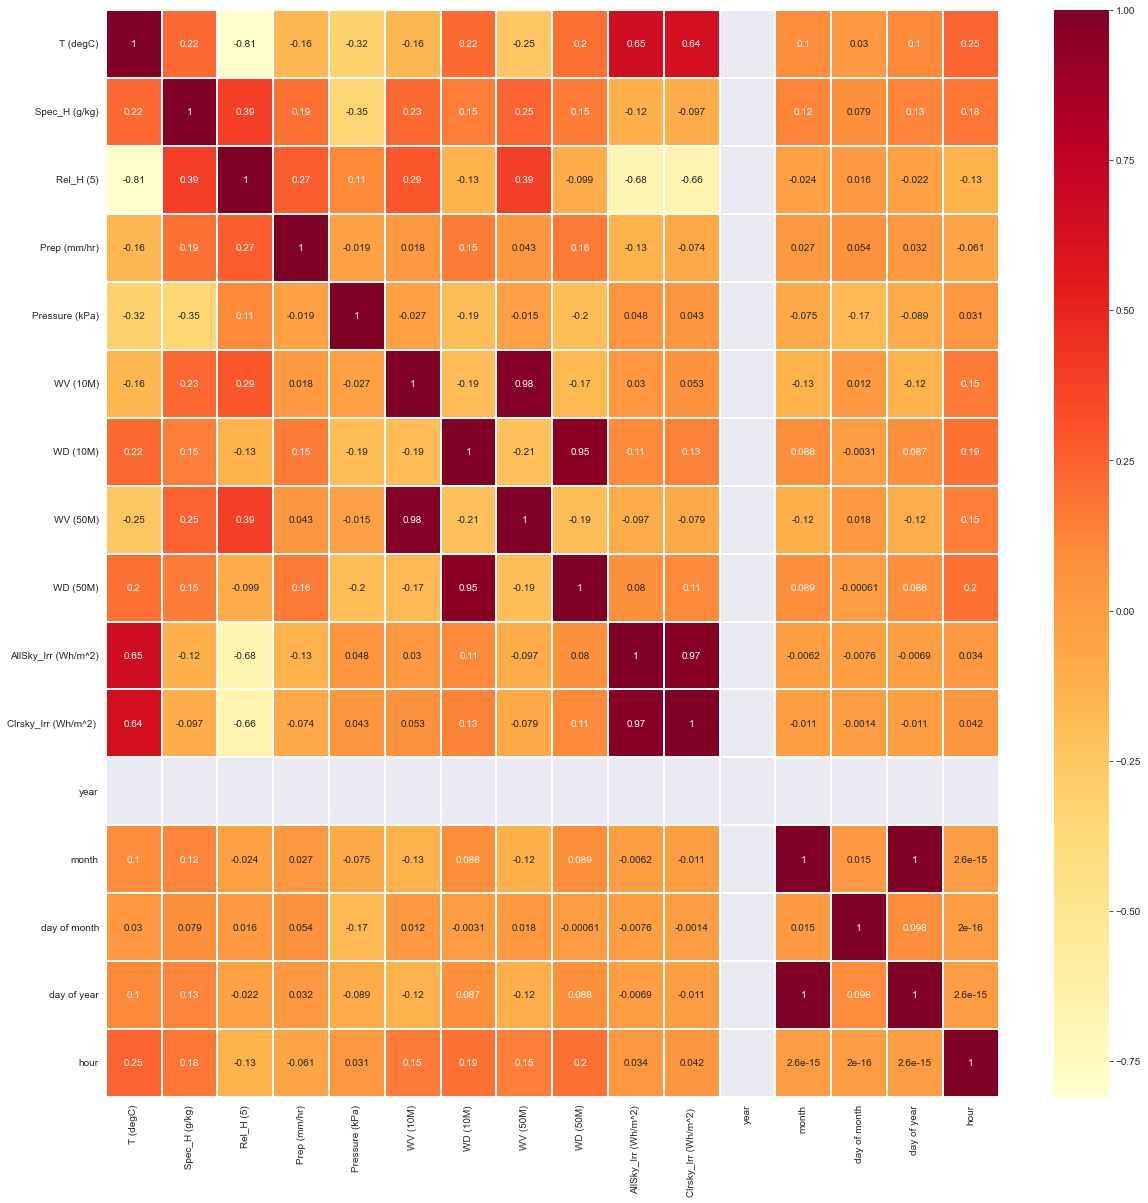

In [91]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, cmap="YlOrRd", linewidths=0.1, annot_kws={"fontsize":10});

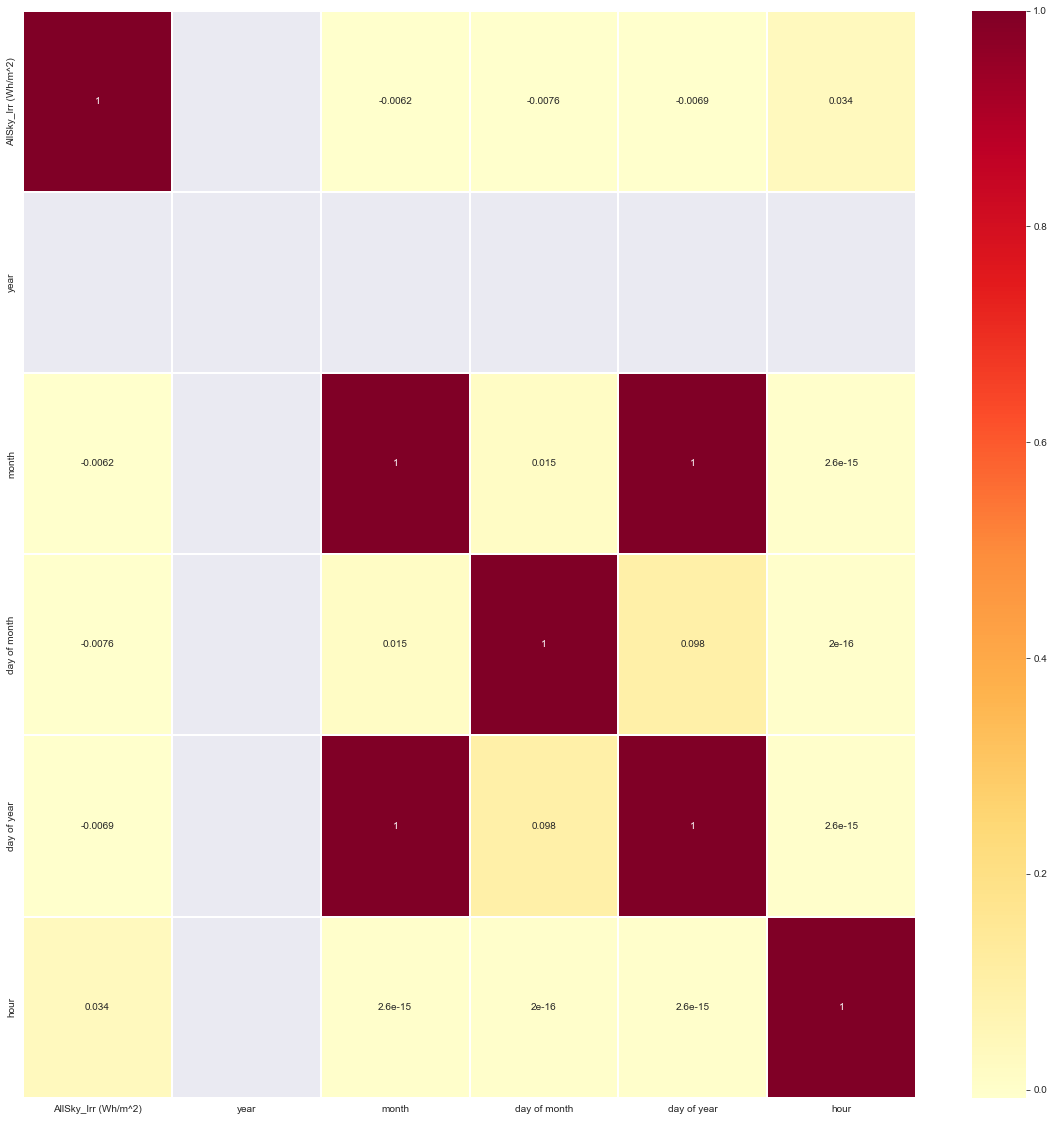

In [92]:
data = data.set_index('Date Time')[['AllSky_Irr (Wh/m^2)','year','month','day of month','day of year','hour']]
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, cmap="YlOrRd", linewidths=0.1, annot_kws={"fontsize":10});

In [93]:
# Creating train and test sets:
X = data.drop(['AllSky_Irr (Wh/m^2)'], axis =1)
y = data[['AllSky_Irr (Wh/m^2)']]

# Scaling the data. 
data_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()


scaled_data = data_scaler.fit_transform(X.values)
scaled_target = target_scaler.fit_transform(y.values)

scaled_data= pd.DataFrame(scaled_data, index=X.index, columns=X.columns)
scaled_target= pd.DataFrame(scaled_target, index=y.index, columns=y.columns)

x_train, x_test, y_train, y_test = train_test_split(scaled_data,scaled_target,test_size=0.1,shuffle=False, stratify = None)

In [94]:
x_train

,year,month,day of month,day of year,hour
Date Time,,,,,
2019-01-01 00:00:00,0.0,0.000000,0.0,0.000000,0.000000
2019-01-01 01:00:00,0.0,0.000000,0.0,0.000000,0.043478
2019-01-01 02:00:00,0.0,0.000000,0.0,0.000000,0.086957
2019-01-01 03:00:00,0.0,0.000000,0.0,0.000000,0.130435
2019-01-01 04:00:00,0.0,0.000000,0.0,0.000000,0.173913
...,...,...,...,...,...
2019-11-25 11:00:00,0.0,0.909091,0.8,0.901099,0.478261
2019-11-25 12:00:00,0.0,0.909091,0.8,0.901099,0.521739
2019-11-25 13:00:00,0.0,0.909091,0.8,0.901099,0.565217


## LSTM:

In [95]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
7840/7840 [==============================] - 45s 5ms/step - loss: 0.0654
Epoch 2/5
7840/7840 [==============================] - 39s 5ms/step - loss: 0.0114
Epoch 3/5
7840/7840 [==============================] - 39s 5ms/step - loss: 0.0083
Epoch 4/5
7840/7840 [==============================] - 39s 5ms/step - loss: 0.0072
Epoch 5/5
7840/7840 [==============================] - 39s 5ms/step - loss: 0.0068


In [96]:
LSTMpredictions = model.predict(x_test)
LSTMpredictions = target_scaler.inverse_transform(LSTMpredictions)

lstmmae = mean_absolute_error(y_test, LSTMpredictions)
lstmmse = mean_squared_error(y_test, LSTMpredictions)
lstmrmse = np.sqrt(lstmmse)
lstmr2 = r2_score(y_test, LSTMpredictions)
print(f'''
(a) LSTM Mean Absolute Error (lstmMAE): {lstmmae}
(b) LSTM Mean Squared Error (MlstmSE): {lstmmse}
(c) LSTM Root Mean Squared Errlstmor (RMSE): {lstmrmse}
(d) LSTM R² (R-Squared): lstm{lstmr2}
''')

28/28 [==============================] - 1s 5ms/step

(a) LSTM Mean Absolute Error (lstmMAE): 237.2069943209334
(b) LSTM Mean Squared Error (MlstmSE): 130816.05924441156
(c) LSTM Root Mean Squared Errlstmor (RMSE): 361.6850276752019
(d) LSTM R² (R-Squared): lstm-1641275.6597616975



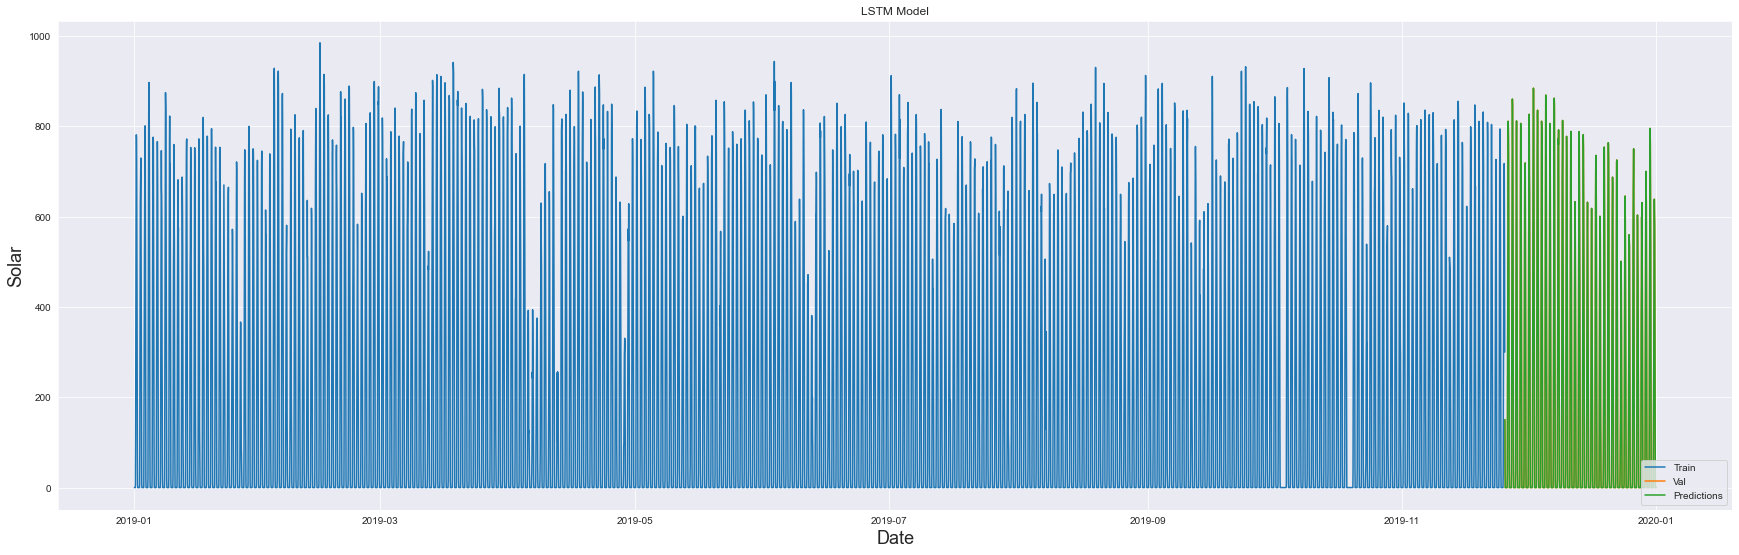

In [97]:
# Plot the data
train = data[:len(x_train)]
valid = data[len(x_train):]
valid['Predictions'] = LSTMpredictions
# Visualize the data
plt.figure(figsize=(30,9))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(valid['AllSky_Irr (Wh/m^2)'])
plt.plot(valid['AllSky_Irr (Wh/m^2)'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

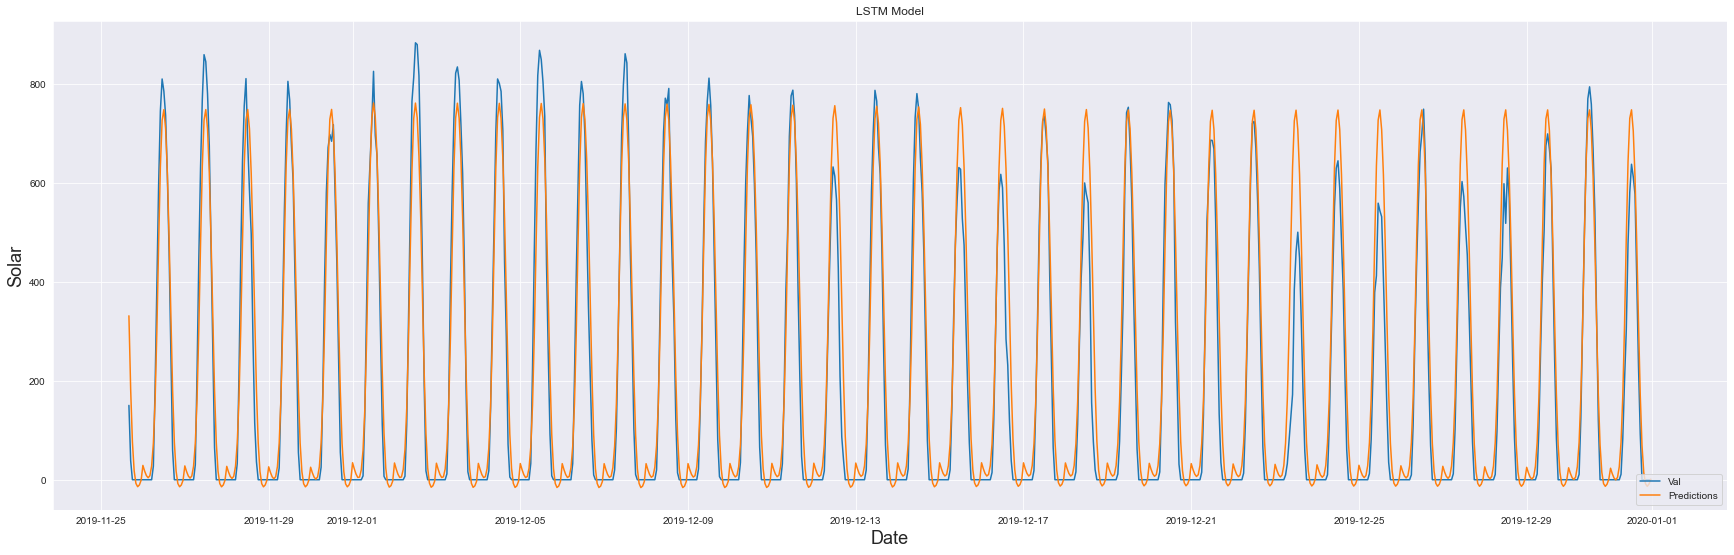

In [98]:
plt.figure(figsize=(30,9))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(valid[['AllSky_Irr (Wh/m^2)', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

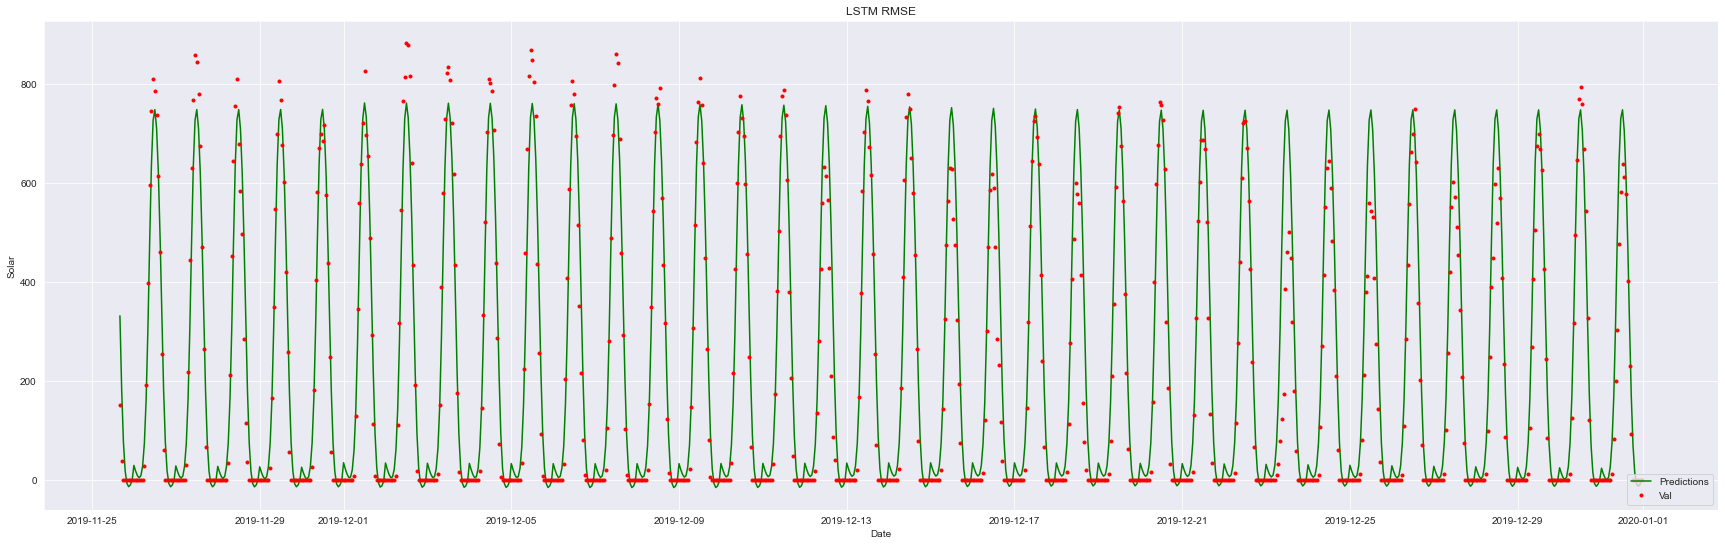

In [99]:
plt.figure(figsize=(30,9))
plt.plot(valid['Predictions'],'g-',label="Predictions")
plt.plot(valid['AllSky_Irr (Wh/m^2)'],'r.',label="Val")
plt.ylabel('Solar')
plt.xlabel('Date')
plt.legend( loc='lower right')
plt.title('LSTM RMSE')
plt.grid(True)

## KNN:

In [101]:
KNN_grid = {'n_neighbors' : list(range(3,100,2))}

knn = KNeighborsRegressor()

grid = GridSearchCV(knn, KNN_grid).fit(x_train,y_train)

In [102]:
knn = grid.best_estimator_
knn

KNeighborsRegressor(n_neighbors=15)

In [ ]:
knn.fit(x_train,y_train)
KNN_pred = knn.predict(x_test)
KNN_pred = target_scaler.inverse_transform(KNN_pred)

knnmae = mean_absolute_error(y_test, KNN_pred)
knnmse = mean_squared_error(y_test, KNN_pred)
knnrmse = np.sqrt(knnmse)
knnr2 = r2_score(y_test, KNN_pred)
print(f'''
(a) KNN Mean Absolute Error (MAE): {knnmae}
(b) KNN Mean Squared Error (MSE): {knnmse}
(c) KNN Root Mean Squared Error (RMSE): {knnrmse}
(d) KNN R² (R-Squared): {knnr2}
''')


(a) KNN Mean Absolute Error (MAE): 217.5197151053041
(b) KNN Mean Squared Error (MSE): 117206.26098338504
(c) KNN Root Mean Squared Error (RMSE): 342.35399951422363
(d) KNN R² (R-Squared): -1470521.0570094944



In [ ]:
knn.score(x_test,y_test)

0.9413525261239502

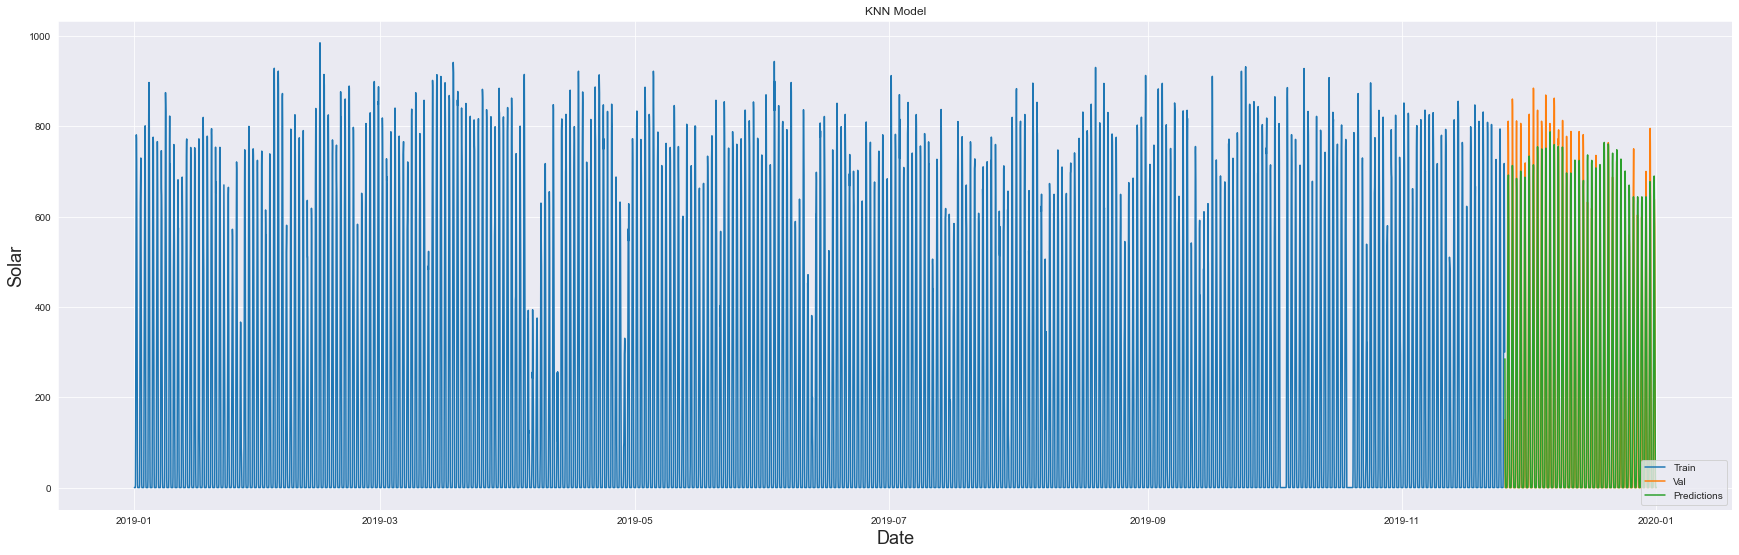

In [ ]:
# Plot the data
train = data[:len(x_train)]
valid = data[len(x_train):]
valid['Predictions'] = KNN_pred
# Visualize the data
plt.figure(figsize=(30,9))
plt.title('KNN Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(valid[['AllSky_Irr (Wh/m^2)', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

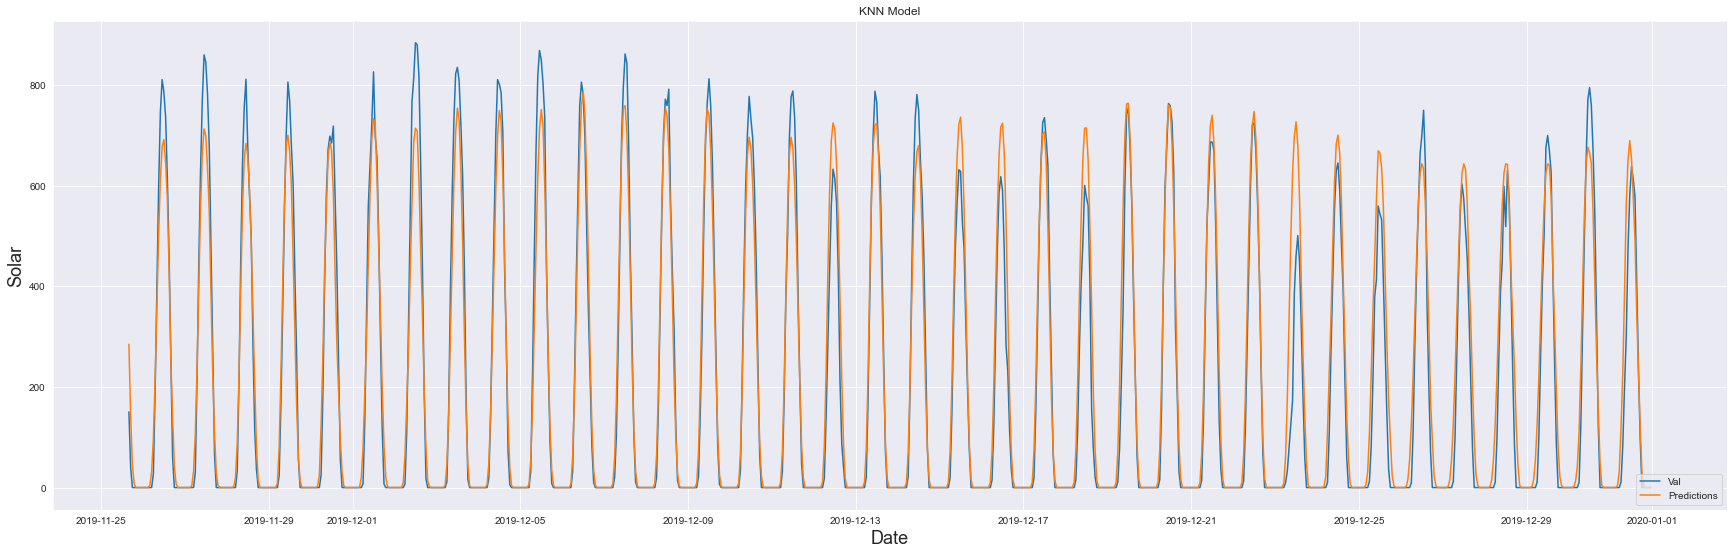

In [ ]:
# Visualize the data
plt.figure(figsize=(30,9))
plt.title('KNN Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(valid[['AllSky_Irr (Wh/m^2)', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

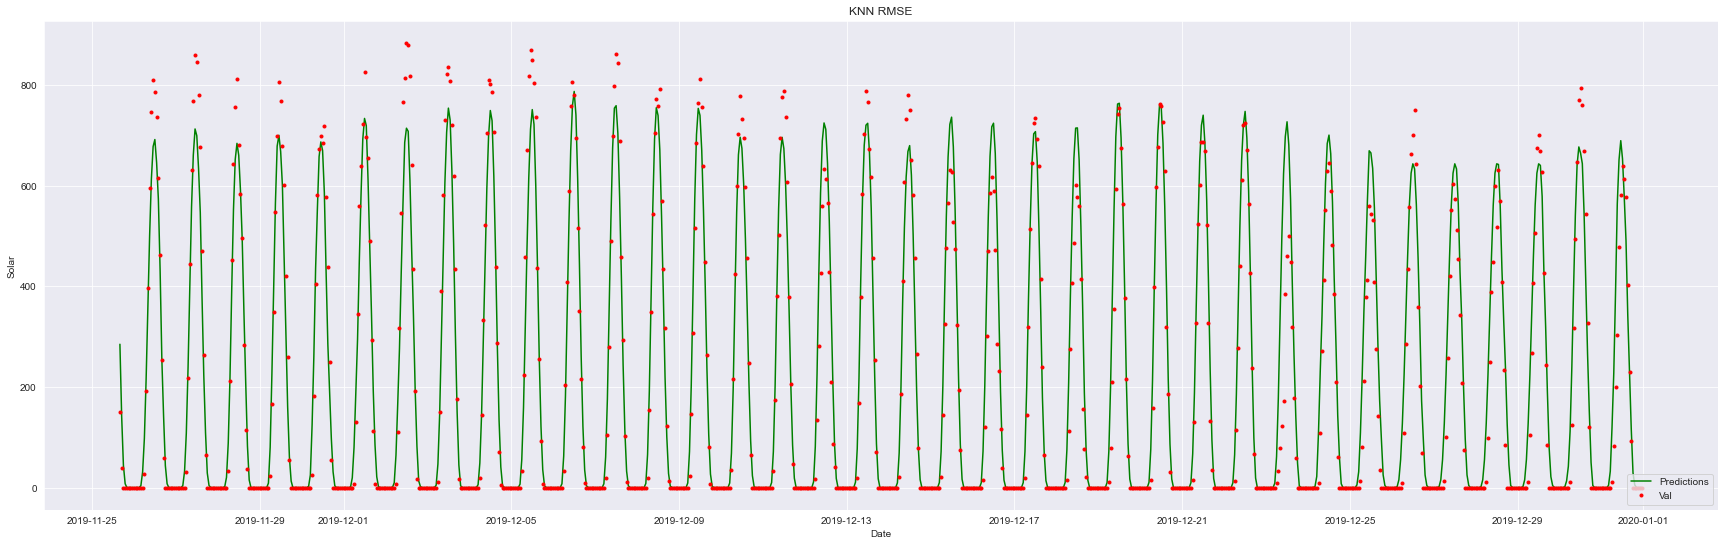

In [ ]:
plt.figure(figsize=(30,9))
plt.plot(valid['Predictions'],'g-',label="Predictions")
plt.plot(valid['AllSky_Irr (Wh/m^2)'],'r.',label="Val")
plt.ylabel('Solar')
plt.xlabel('Date')
plt.legend( loc='lower right')
plt.title('KNN RMSE')
plt.grid(True)

## SVR:

In [ ]:
param = {'kernel' : ('linear', 'poly', 'rbf'),'C' : [1,10],'coef0' : [0.01,1],'gamma' : ('auto','scale')}

svr = SVR()

grids = GridSearchCV(svr,param,cv=5)

grids.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1, 10], 'coef0': [0.01, 1],
                         'gamma': ('auto', 'scale'),
                         'kernel': ('linear', 'poly', 'rbf')})

In [ ]:
svr = grids.best_estimator_
svr

SVR(C=10, coef0=0.01)

In [ ]:
svr.fit(x_train,y_train)
svr_pred = svr.predict(x_test)
svr_pred = target_scaler.inverse_transform(svr_pred.reshape(-1, 1))

svrmae = mean_absolute_error(y_test, svr_pred)
svrmse = mean_squared_error(y_test, svr_pred)
svrrmse = np.sqrt(svrmse)
svrr2 = r2_score(y_test, svr_pred)
print(f'''
(a) svr Mean Absolute Error (MAE): {svrmae}
(b) svr Mean Squared Error (MSE): {svrmse}
(c) svr Root Mean Squared Error (RMSE): {svrrmse}
(d) svr R² (R-Squared): {svrr2}
''')


(a) svr Mean Absolute Error (MAE): 235.56329593908436
(b) svr Mean Squared Error (MSE): 99800.49238904001
(c) svr Root Mean Squared Error (RMSE): 315.9121592928009
(d) svr R² (R-Squared): -1252140.5163930175



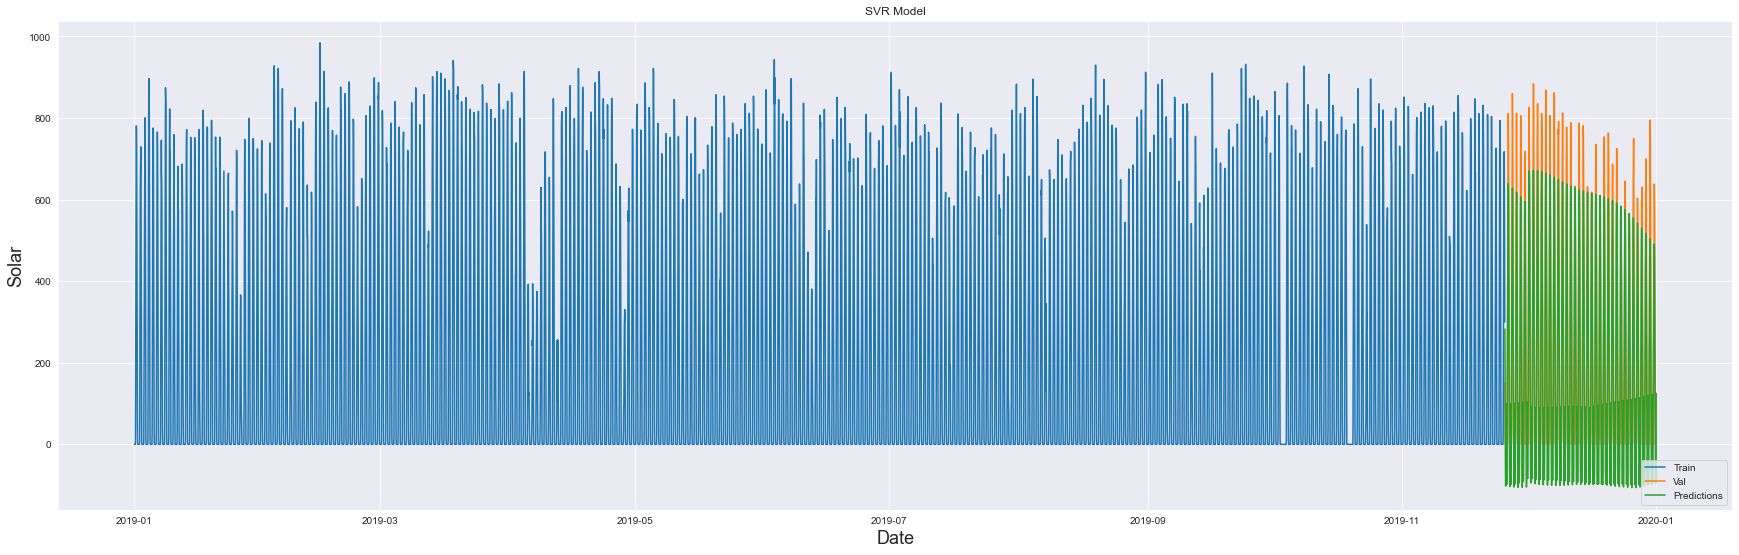

In [ ]:
# Plot the data
train = data[:len(x_train)]
valid = data[len(x_train):]
valid['Predictions'] = svr_pred

# Visualize the data
plt.figure(figsize=(30,9))
plt.title('SVR Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(valid[['AllSky_Irr (Wh/m^2)', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

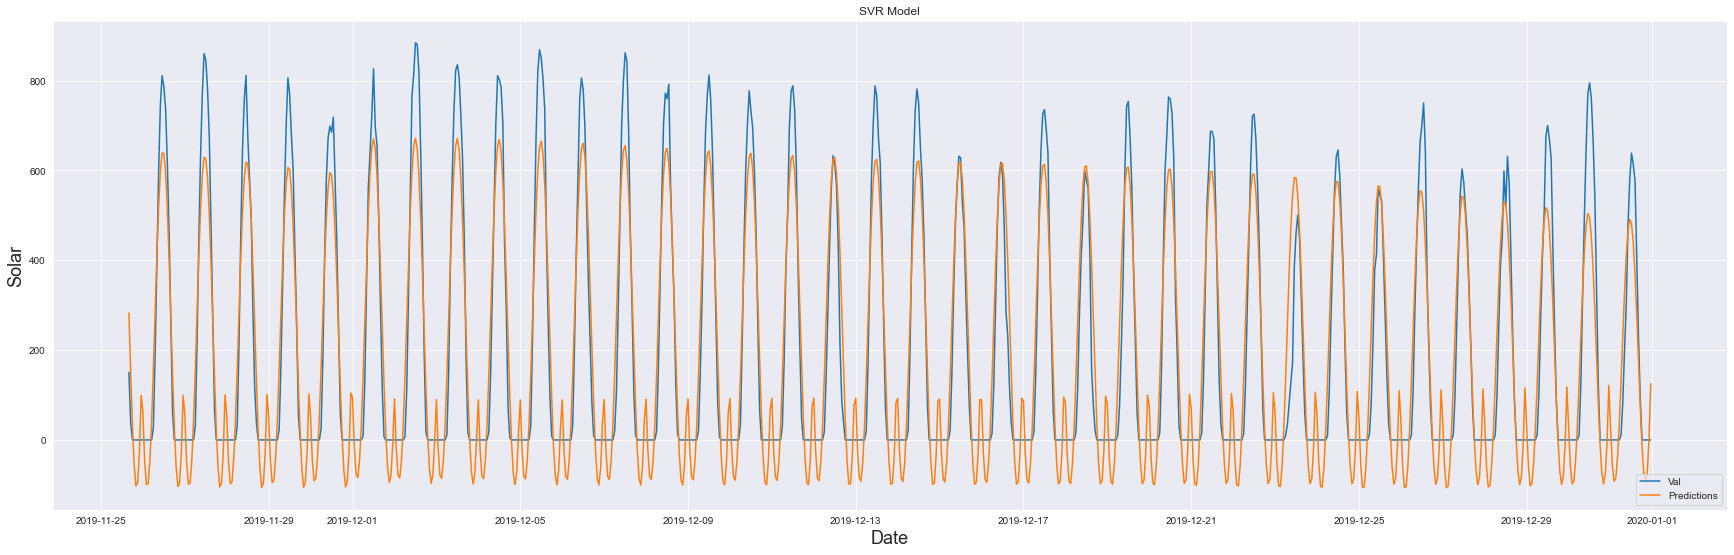

In [ ]:
# Visualize the data
plt.figure(figsize=(30,9))
plt.title('SVR Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(valid[['AllSky_Irr (Wh/m^2)', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

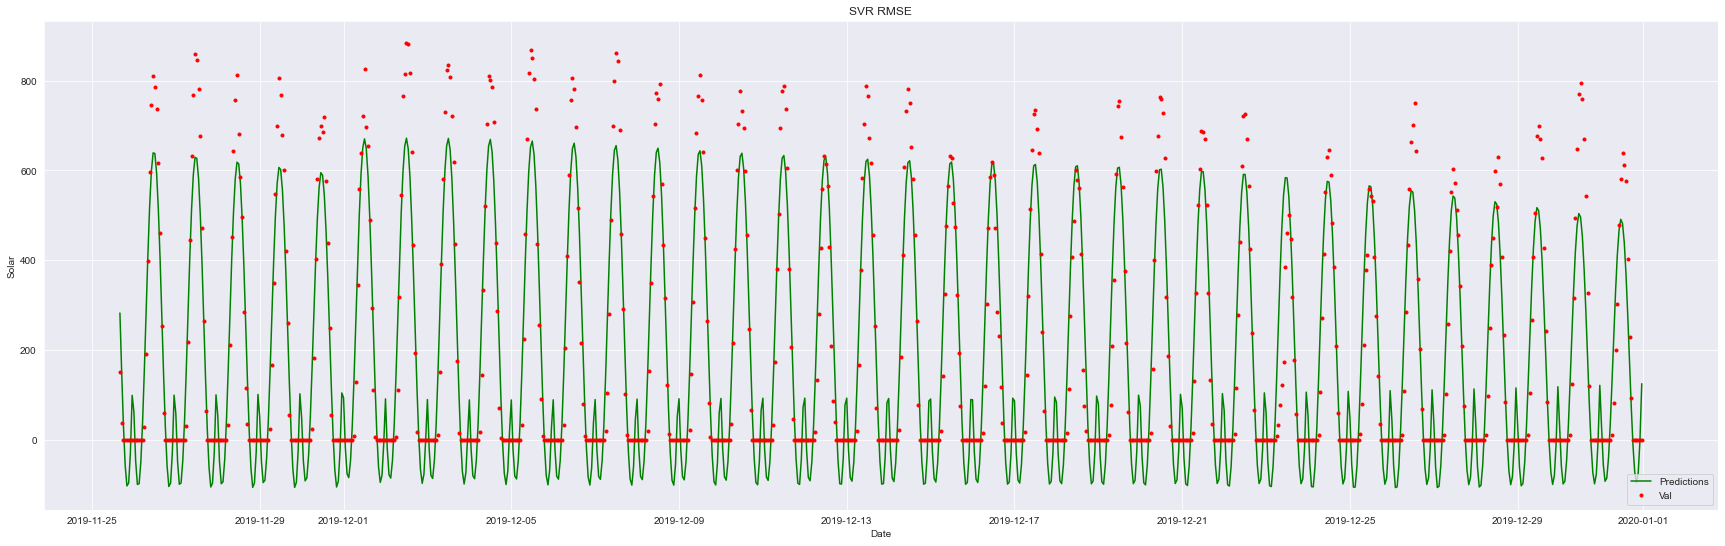

In [ ]:
plt.figure(figsize=(30,9))
plt.plot(valid['Predictions'],'g-',label="Predictions")
plt.plot(valid['AllSky_Irr (Wh/m^2)'],'r.',label="Val")
plt.ylabel('Solar')
plt.xlabel('Date')
plt.legend( loc='lower right')
plt.title('SVR RMSE')
plt.grid(True)

#### Grouped:

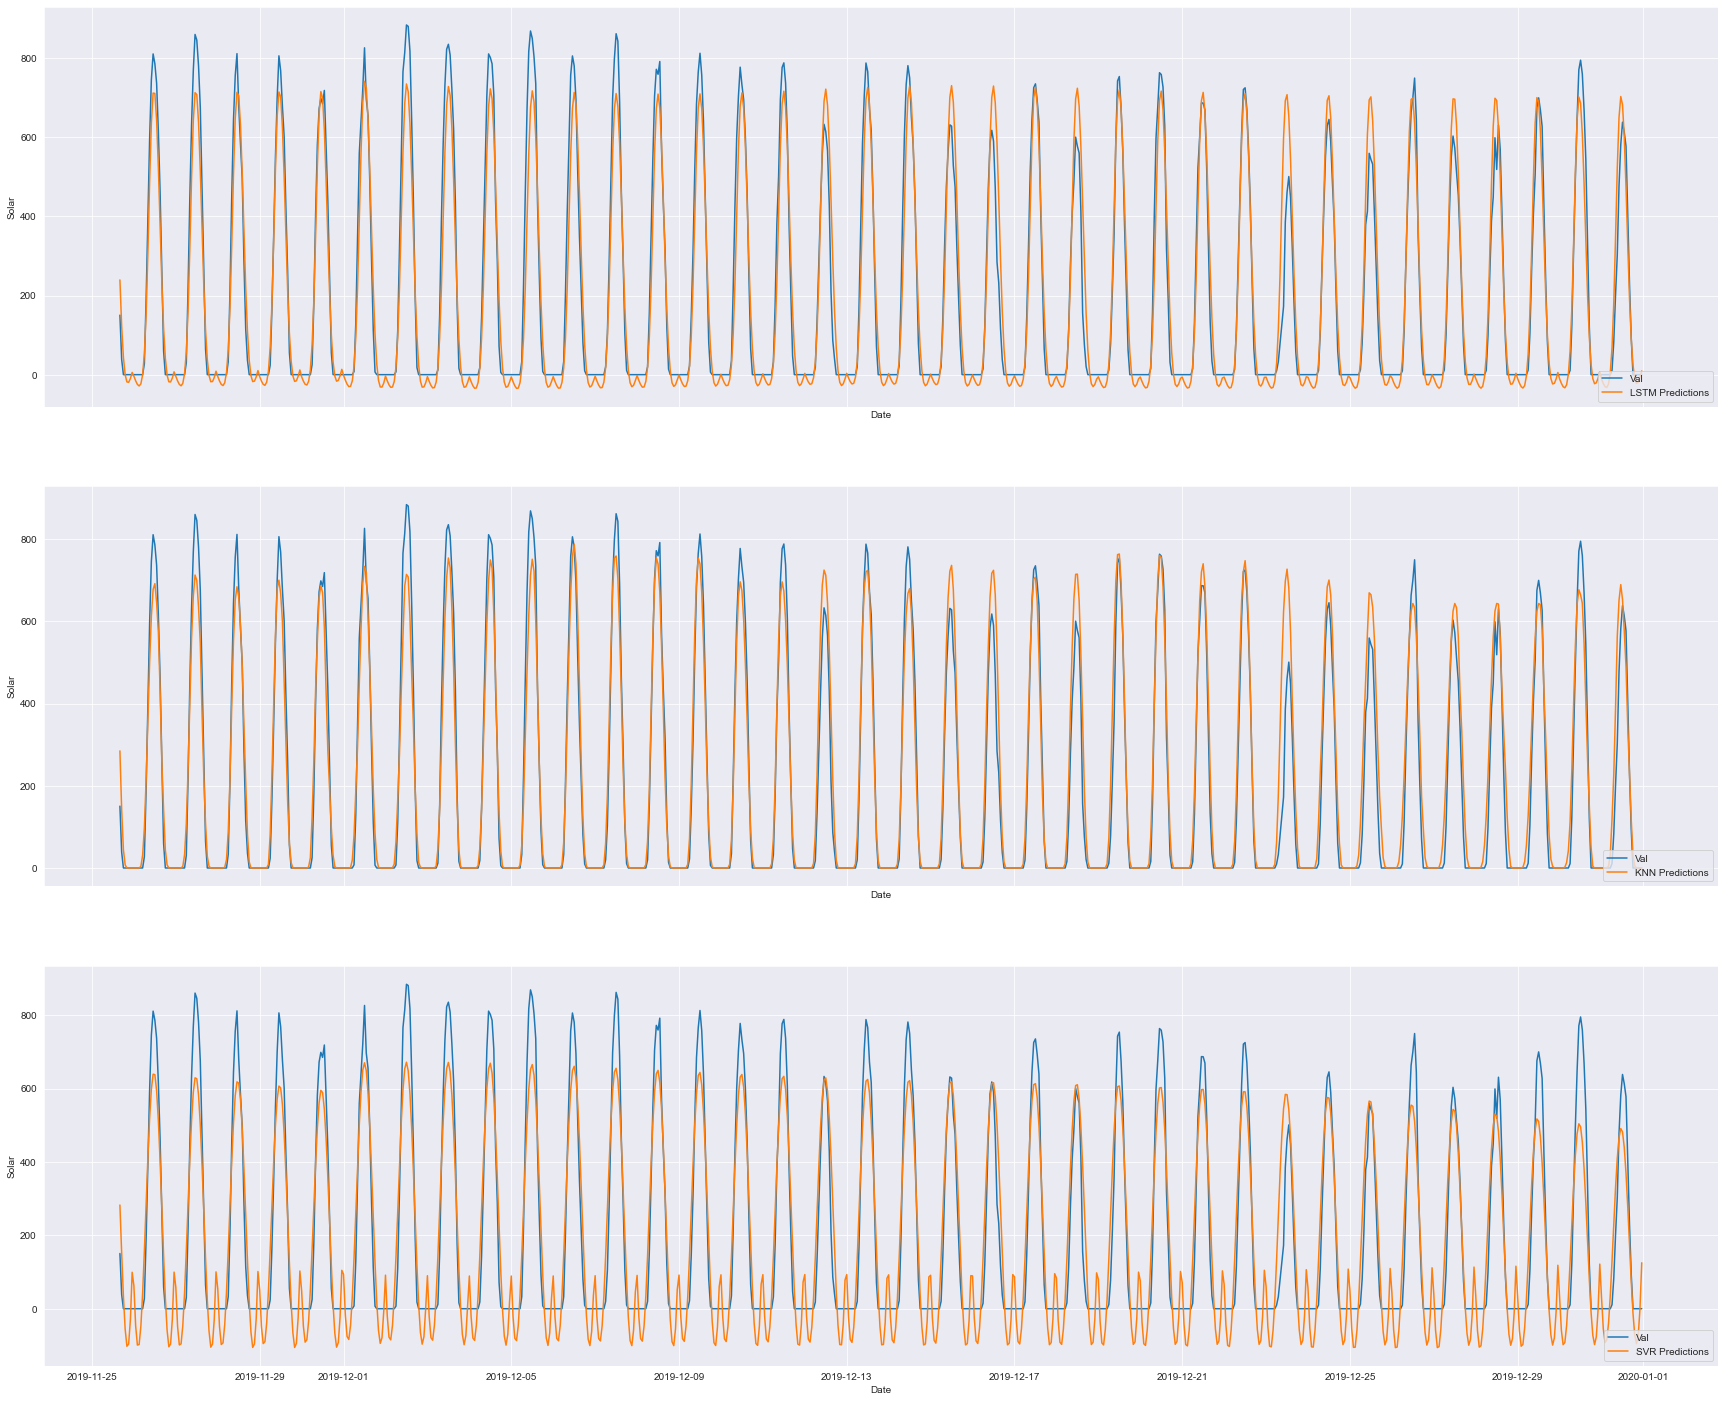

In [ ]:
fig, ax = plt.subplots(3,1,sharex=True)
fig.set_size_inches(30,25)

for pred,model_,n in zip([LSTMpredictions,KNN_pred,svr_pred],['LSTM','KNN','SVR'],[0,1,2]):

    # Plot the data
    train = data[:len(x_train)]
    valid = data[len(x_train):]
    valid['Predictions'] = pred

    ax[n].plot(valid[['AllSky_Irr (Wh/m^2)', 'Predictions']])
    
    ax[n].set_ylabel('Solar')
    ax[n].set_xlabel('Date')
    ax[n].legend(['Val', model_+' Predictions'], loc='lower right')
    ax[n].grid(True)




In [ ]:
fh = open('svr.pickle','wb')
pickle.dump(svr,fh)
fh = open('LSTM.pickle','wb')
pickle.dump(model,fh)
fh = open('KNN.pickle','wb')
pickle.dump(knn,fh)

In [ ]:
fh = open('svr.pickle','rb')
SVR = pickle.load(fh)
fh = open('LSTM.pickle','rb')
LSTM = pickle.load(fh)
fh = open('KNN.pickle','rb')
KNN = pickle.load(fh)

## RMSE:

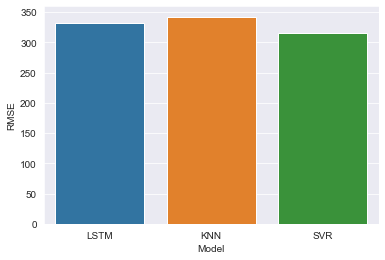

In [ ]:
df = pd.DataFrame([[lstmrmse,knnrmse,svrrmse],['LSTM','KNN','SVR']]).T
df.columns=['RMSE','Model']
sns.barplot(data=df, x="Model", y="RMSE");

## MAE:

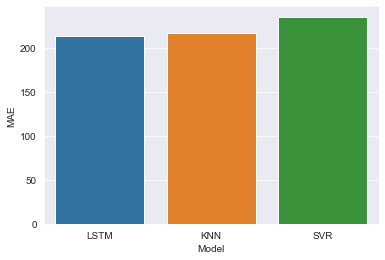

In [ ]:
df = pd.DataFrame([[lstmmae,knnmae,svrmae],['LSTM','KNN','SVR']]).T
df.columns=['MAE','Model']
sns.barplot(data=df, x="Model", y="MAE");

## Future Predictions:

In [ ]:
x_test.tail()

,year,month,day of month,day of year,hour
Date Time,,,,,
2019-12-31 19:00:00,0.0,1.0,1.0,1.0,0.826087
2019-12-31 20:00:00,0.0,1.0,1.0,1.0,0.869565
2019-12-31 21:00:00,0.0,1.0,1.0,1.0,0.913043
2019-12-31 22:00:00,0.0,1.0,1.0,1.0,0.956522
2019-12-31 23:00:00,0.0,1.0,1.0,1.0,1.000000


In [ ]:
day = x_test.iloc[-24:,:]
day = data_scaler.inverse_transform(day)
day

array([[2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 0.000e+00],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 1.000e+00],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 2.000e+00],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 3.000e+00],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 4.000e+00],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 5.000e+00],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 6.000e+00],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 7.000e+00],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 8.000e+00],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 9.000e+00],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 1.000e+01],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 1.100e+01],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 1.200e+01],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 1.300e+01],
       [2.019e+03, 1.200e+01, 3.100e+01, 3.650e+02, 1.400e+01],
       [2.019e+03, 1.200e+01, 3.100e+01,

In [ ]:
day[:,1:-1] = 1
day[:,0] = 2020
day

array([[2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 0.00e+00],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 2.00e+00],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 3.00e+00],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 4.00e+00],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 5.00e+00],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 6.00e+00],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 7.00e+00],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 8.00e+00],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 9.00e+00],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+01],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 1.10e+01],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 1.20e+01],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 1.30e+01],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 1.40e+01],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 1.50e+01],
       [2.02e+03, 1.00e+00, 1.00e+00, 1.00e+00, 1.60e+01

In [104]:
day = data_scaler.transform(day)
LSTMpredictions = model.predict(day)
LSTMpredictions = target_scaler.inverse_transform(LSTMpredictions)

KNN_pred = knn.predict(day)
KNN_pred = target_scaler.inverse_transform(KNN_pred)

svr_pred = svr.predict(day)
svr_pred = target_scaler.inverse_transform(svr_pred.reshape(-1, 1))

1/1 [==============================] - 0s 33ms/step


In [121]:
preds = pd.DataFrame(pd.DataFrame([LSTMpredictions[:,0],KNN_pred[:,0],svr_pred[:,0]]).T.values,columns=['LSTM','KNN','SVR'])
preds

,LSTM,KNN,SVR
0,42.363941,0.0,951.1874
1,42.338413,0.0,951.1874
2,42.312622,0.0,951.1874
3,42.286964,0.0,951.1874
4,42.261299,0.0,951.1874
5,42.235729,0.0,951.1874
6,42.210068,0.0,951.1874
7,42.184380,0.0,951.1874
8,42.158737,0.0,951.1874
9,42.133095,0.0,951.1874
